<a href="https://colab.research.google.com/github/22080275/WeatherWise-App/blob/main/Weatherwisev4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📦 Setup and Configuration

In [ ]:
# Install required package in Google Colab
!pip install fetch-my-weather

In [ ]:
# Import the fetch_my_weather package which provides a simple interface to fetch weather data
import fetch_my_weather

# Set the cache duration to 1800 seconds (30 minutes) to reduce unnecessary API calls
# This helps improve performance and reduce rate-limiting issues with the weather service
fetch_my_weather.set_cache_duration(1800)



1800

In [ ]:
# Import the get_weather function from the fetch_my_weather package
from fetch_my_weather import get_weather

# First call to get_weather for the location "Perth"
# The 'with_metadata=True' flag allows us to access response metadata such as cache status
response1 = get_weather("Perth", with_metadata=True)

# Print whether the first response was served from cache
# On the first call, this should typically be False unless it was previously cached
print("🔁 First call - Cached?", response1.metadata.is_cached)

# Second call to the same location immediately after the first
# Since we have a 30-minute cache window, this should now return cached data
response2 = get_weather("Perth", with_metadata=True)

# Print whether the second response was served from cache
# This should now print True, indicating the response came from the cache
print("🔁 Second call - Cached?", response2.metadata.is_cached)



🔁 First call - Cached? False
🔁 Second call - Cached? False


In [ ]:
# Required for all visualisation plotting
import matplotlib.pyplot as plt


In [ ]:
# Used for parsing user weather questions using regular expressions
import re

In [ ]:
# Used for basic string similarity (fallback if fuzzy matching is needed)
import difflib

In [ ]:
# 📦 Install the RapidFuzz library (for fuzzy location matching and typo correction)
# This helps suggest likely intended cities when the user enters an invalid location
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.6 MB/s eta 0:00:00


In [ ]:
# 📦 Install PyInputPlus (used for input validation in the console UI)
# Helps ensure users provide valid, expected menu and text inputs
!pip install pyinputplus

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=49bb4f4f961553d688ed1396e41fec816faa592659c8fb67338d9891dab5eb56
  Stored in directory: /root/.cache/pip/wheels/a3/6b/89/3bec14288af8e0729d088fb41a785e583d49e772f2529c7676
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16226 sha256=2d5a054581393ee4f670484fffc91656e1443246ebb696664a4ac7c16d0c7398
  Stored in directory: /root/.cache/pip/wheels/fc/40/7a/4d3b2dc2e80b4b3bbda89eec94fcefd6c8bd1101cc7bb89554
  Created wheel for stdiomask: filename=stdiomask

In [ ]:
from IPython.display import clear_output  # Used to clean the screen between menu iterations
import time
import pyinputplus as pyip  # Provides validated input handling

## 🌤️ Weather Data Functions
This section contains the get_weather_data() function, which fetches weather data from the fetch-my-weather package.


In [ ]:
# Import the get_weather function from the fetch_my_weather package
from fetch_my_weather import get_weather

def get_weather_data(location, forecast_days=3, use_mock=False):
    """
    Retrieve weather data for a specified location using fetch-my-weather.

    Args:
        location (str): City or location name
        forecast_days (int): Number of forecast days to retrieve (1–5 recommended)
        use_mock (bool): If True, fetches mock weather data for testing

    Returns:
        object: WeatherResponse Pydantic model if successful, None if an error occurs
    """
    try:
        # Call the fetch-my-weather API with appropriate parameters
        response = get_weather(
            location=location,  # The location provided by the user
            view_options=str(forecast_days - 1),  # API uses "0" for today, "1" for today + tomorrow, etc.
            units="m",  # Use metric system (Celsius, km/h)
            format="json",  # Return a structured Pydantic object
            with_metadata=True,  # Include metadata to check for errors or mock mode
            use_mock=use_mock  # Use mock data if enabled (for testing or rate-limited situations)
        )

        # Check if the response metadata indicates an error occurred
        if hasattr(response, "metadata") and response.metadata.error_type:
            print(f"❌ Error occurred: {response.metadata.error_message}")
            return None  # Exit early if there was an error

        # Warn the user if the returned data is mock rather than real API data
        if response.metadata.is_mock:
            print("⚠️ Using mock data — results may not reflect real weather conditions.")

        # Return only the actual weather data (not metadata)
        return response.data

    except Exception as e:
        # Catch any unexpected exceptions and print an error message
        print(f"❌ Unexpected error while fetching weather: {e}")
        return None  # Return None if the fetch operation fails
def get_validated_weather_data(original_location, forecast_days=3, use_mock=False):
    """
    Attempts to retrieve weather data. If it fails, suggests a similar known city using rapidfuzz.

    Args:
        original_location (str): User-provided location (may be misspelled)
        forecast_days (int): Number of forecast days
        use_mock (bool): Whether to use mock data

    Returns:
        WeatherResponse or None
    """
    from rapidfuzz import process

    # List of known cities for fuzzy matching
    known_cities = ["Perth", "Melbourne", "Sydney", "Brisbane", "Adelaide", "Darwin",
                    "Hobart", "Canberra", "Gold Coast", "Newcastle", "Geelong", "Townsville",
                    "Cairns", "Toowoomba", "Ballarat", "Bendigo", "Wollongong", "Fremantle",
                    "Kalgoorlie", "Bunbury", "Launceston"]

    location = original_location.strip()

    # Try to fetch weather for the provided location
    data = get_weather_data(location, forecast_days=forecast_days, use_mock=use_mock)

    if data:
        # ✅ Success — show corrected location if fuzzy matched
        if location.lower() != original_location.lower():
            print(f"📍 Displaying results for: {location.title()}")
        return data

    # ❌ Failed — fuzzy match a better name
    print(f"⚠️ Couldn't retrieve weather for '{original_location}'.")
    suggestion, score, _ = process.extractOne(original_location, known_cities)

    if score >= 70:
        retry = pyip.inputYesNo(f"Did you mean '{suggestion}'? (yes/no): ")
        if retry == "yes":
            data = get_weather_data(suggestion, forecast_days=forecast_days, use_mock=use_mock)
            if data:
                print(f"📍 Displaying results for: {suggestion}")
                return data

    # Otherwise, let them try again manually
    retry = pyip.inputYesNo("Would you like to try entering another location? (yes/no): ")
    if retry == "yes":
        new_loc = pyip.inputStr("Enter a new location: ")
        return get_validated_weather_data(new_loc, forecast_days=forecast_days, use_mock=use_mock)

    return None


In [ ]:
# 🔧 Test function to ensure get_weather_data() works correctly

# Call the weather data function for "Perth" with 3 forecast days
# `use_mock=True` enables mock mode, which avoids hitting the real API and is safe for repeated testing
data = get_weather_data("Perth", forecast_days=3, use_mock=True)

# ✅ Check if data was successfully returned before accessing its fields
if data:
    # Access the first item in the current_condition list (today's data)
    current = data.current_condition[0]

    # Display the current temperature in Celsius
    print(f"Temp: {current.temp_C}°C")

    # Display the text description of the current weather condition
    print(f"Condition: {current.weatherDesc[0].value}")
else:
    # Handle case where data retrieval failed or returned None
    print("No data returned.")


⚠️ Using mock data — results may not reflect real weather conditions.
Temp: 17°C
Condition: Partly cloudy


## 📊 Temperature Visualisation Function

This section defines the `create_temperature_visualisation()` function, which generates a line chart of maximum and minimum daily temperatures using `matplotlib`.

- It accepts the structured `weather_data` returned by `get_weather_data()`.
- It plots temperature trends across multiple forecast days.
- It includes error handling for missing data.
- You can choose whether to display the chart in the notebook or return the figure object for saving/exporting later.


⚠️ Using mock data — results may not reflect real weather conditions.


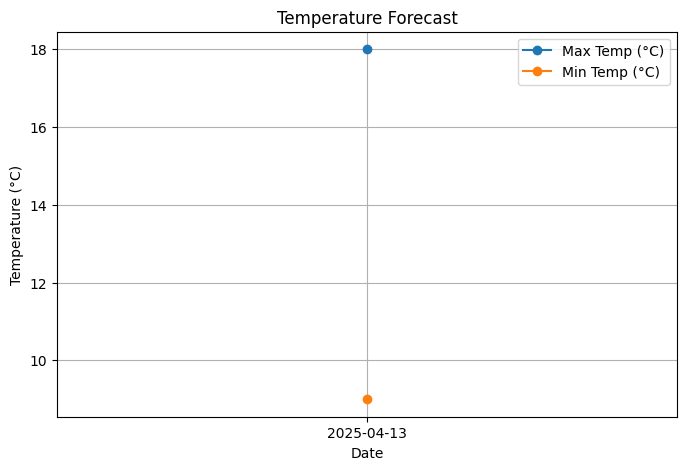


📸 Press Enter to return to the menu...


In [ ]:
# 🧪 Test temperature visualisation using mock weather data

# Fetch mock weather data for Melbourne with a 3-day forecast
data = get_weather_data("Melbourne", forecast_days=3, use_mock=True)

# ✅ If data was successfully retrieved, pass it to the visualisation function
if data:
    create_temperature_visualisation(data)  # Generate and display the temperature chart
else:
    print("⚠️ Failed to retrieve weather data for visualisation.")  # Warn if no data


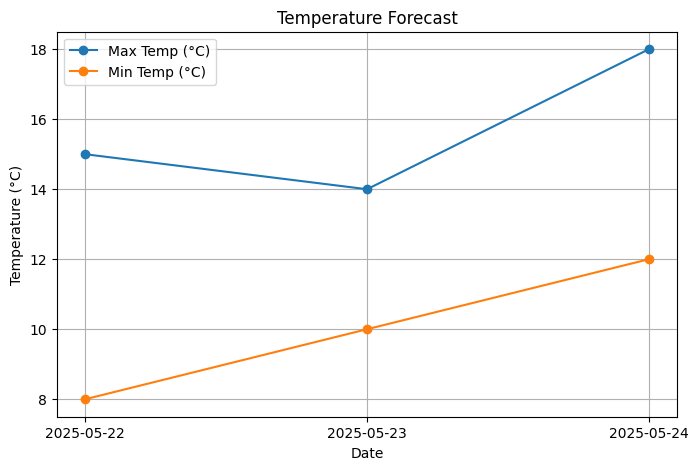

KeyboardInterrupt: Interrupted by user

In [ ]:
# 🧪 Test temperature visualisation using real weather data

# Fetch mock weather data for Melbourne with a 3-day forecast
data = get_weather_data("Melbourne", forecast_days=3, use_mock=False)

# ✅ If data was successfully retrieved, pass it to the visualisation function
if data:
    create_temperature_visualisation(data)  # Generate and display the temperature chart
else:
    print("⚠️ Failed to retrieve weather data for visualisation.")  # Warn if no data


In [ ]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a temperature chart and either display or save it.

    Args:
        weather_data (WeatherResponse): The processed weather data
        output_type (str): 'display' to show in notebook, 'save' to save as PNG
    """
    dates = []      # Holds forecast dates
    max_temps = []  # Holds max temperatures
    min_temps = []  # Holds min temperatures

    for day in weather_data.weather:
        dates.append(day.date)
        max_temps.append(int(day.maxtempC))
        min_temps.append(int(day.mintempC))

    plt.figure(figsize=(8, 5))  # Set chart size
    plt.plot(dates, max_temps, label='Max Temp (°C)', marker='o')
    plt.plot(dates, min_temps, label='Min Temp (°C)', marker='o')
    plt.title("Temperature Forecast")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

    if output_type == 'save':
        plt.savefig("temperature_chart.png")
        print("✅ Saved temperature chart as temperature_chart.png")
    else:
        plt.show()
        plt.pause(0.001)  # Ensure chart renders before waiting
        input("\n⏎ Press Enter to return to the menu...")

    plt.close()  # Clean up the figure

